## Overview

In this notebook, I will be implementing ***multiple linear regression*** from stratch. 

We will then move onto modifying the algorithm to work for logistic regression. 

Finally, we will use regularisation to handle overfitting. 


### Importing necessary libraries

In [34]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

In [35]:
df = pd.read_csv("../datasets/Student_Performance.csv")
df.drop(columns=["Extracurricular Activities"], inplace=True)

### No NaNs

In [36]:
df.isna().sum()

Hours Studied                       0
Previous Scores                     0
Sleep Hours                         0
Sample Question Papers Practiced    0
Performance Index                   0
dtype: int64

### Loading Training & Test Data.

Link to dataset --> https://kaggle.com/datasets/nikhil7280/student-performance-multiple-linear-regression


In [37]:
df.columns

Index(['Hours Studied', 'Previous Scores', 'Sleep Hours',
       'Sample Question Papers Practiced', 'Performance Index'],
      dtype='object')

## Splitting the dataset into X & y

In [38]:
X = df[['Hours Studied', 'Previous Scores', 'Sleep Hours',
       'Sample Question Papers Practiced',]]

In [39]:
y = df[['Performance Index']]

## Train Test Split

In [40]:
from sklearn.model_selection import train_test_split

In [41]:
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)
y_train, y_test = train_test_split(y, test_size=0.2, random_state=42)

### Standarisation using Z-Score normalisation

Standardization ensures features are on the same scale, reducing computational complexity. This process is crucial for models that involve gradient-based optimization. 

Gradient descent converges faster when features are scaled because the contours of the cost function become more circular rather than elongated. 

Without standardization, features with larger ranges might dominate the optimization process.

**After z-score normalization, all features will have a mean of 0 and standard deviation of 1.**

To implement z-score normalization, we will adjust our input feature based on the formula below:

$ x_j^{(i)} = \frac{ x_j^{(i)} - \mu_j}{\sigma_j}$


where, *j* selects a feature or a column in the **X** matrix. $\mu_j$ is the mean of all the values for freature(j) and $\sigma_j$ is the standard deviation of feature(j):

$\mu_j = \frac{1}{m} \sum_{i=0}^{m-1}x_j^{(i)}$

$\sigma_j^2 = \frac{1}{m}\sum_{i=0}^{m-1} (x_j^{(i)} - \mu_j)^2$

Since, we only have one feature, the formula reduces to:

$ x{(i)} = \frac{x{(i)} - \mu }{\sigma}$

In [42]:
def normalize_feature(X):
    """
    Normalizes the features in the dataset using z-score standardization.

    Parameters:
    X (numpy.ndarray): A ndarray where each row is a data sample and each column is a feature.

    Returns:
    X_norm (numpy.ndaary): The normalized dataset with zero mean and unit variance for each feature.
    """


    # Calculate the mean of each feature (column-wise)
    mu = np.mean(X, axis=0)

    # Calculate the standard deviation of each feature (column-wise)
    sigma = np.std(X, axis=0)

    # Apply z-score normalization: (X - mean) / standard deviation
    X_norm = (X - mu) / sigma

    # Return the normalized features
    return X_norm

In [43]:
X_train = normalize_feature(X=X_train)

In [44]:
X_train

,Hours Studied,Previous Scores,Sleep Hours,Sample Question Papers Practiced
9254,0.006455,-1.183844,0.269888,0.134041
1561,-1.149747,-1.241506,0.269888,0.483562
1670,-1.149747,0.661318,0.269888,-0.914520
6087,-1.149747,-1.356828,-0.318906,-1.264041
6669,1.162658,-1.299167,1.447477,-1.613561
...,...,...,...,...
5734,1.162658,-1.126183,-0.318906,0.483562
5191,-0.378946,-0.088279,1.447477,-0.565000
5390,1.548059,-1.241506,0.269888,0.483562
860,-1.535148,-1.299167,1.447477,-1.613561


In [45]:
X_test = normalize_feature(X=X_test)

### Reshaping input feature ndarry suitable for vectorisation

In [46]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

In [47]:
y_test  = y_test.to_numpy()
y_train = y_train.to_numpy()

In [48]:
y_test = y_test.ravel()


## Multiple Linear Regression Intuition

The Goal is to implement the model $f_{w,b}$ for linear regression with one variable

We will use $(x^{(i)}, y^{(i)})$ to denote the $i^{(th)}$ training example. 

Since, python is zero indexed
$x^{(0)}, y^{(0)}$ is (24.0, 21.549452) and $x^{(1)}, y^{(1)}$ is (50.0,	47.464463)



The model function for linear regression is represented as

$$f_{\vec w,b} = \vec w \cdot \vec x + b$$

Here,  

$f_{w,b}(x^{(i)})$ represents the model,   $w$ is the weight parameter,  $b$ is the bias parameter, and   $x^{(i)}$ is the input feature.

## How are we going to find the value of $ w, b $ such that  $\hat{y}^{(i)}$ is close to $y ^{(i)}$ for all $(x^{(i)}, y^{(i)})$

where, $\hat y ^{(i)}$ is the output of our model $f_{w,b}(x^{(i)}) = wx^{(i)} + b$. Also, reffered to as prediction.

**Even if we estimate the values for $w$ and $b$, we need a way to see how close our predictions are to the actual output** 

To see how close our prediction $\hat{y}^{(i)}$ is to $y ^{(i)}$. We are going to use **Cost Function.**

Also called, squared error cost function.

This is the most common cost function used for regression models.

$$ J(w,b) = \frac{1}{2m} \sum_{i=1}^{m} (\hat{y}^{(i)} - y^{(i)})^2$$ 

where, 


$m$ = number of training examples 

Eventually, we want to use the values of $w$ and $ b$ such that our cost function is minimised.

**Model**: 

$f_{w,b}(x^{(i)}) = wx^{(i)} + b$

**Parameters:** 

$ w, b $

**Cost Function**

$ J(w,b) = \frac{1}{2m} \sum_{i=1}^{m} (\hat{y}^{(i)} - y^{(i)})^2$ 


**Goal**

$minimize$  $J(w,b)$

#### We will use **Gradient Descent** to minimise our cost function. 

**Top Level Decomposition of Gradient Descent Algorithm**


- Start with some random value of $w$, $b$. Commonly we set $w=0$ and $b=0$.

- Keep changing $w$, $b$ to reduce $J(w,b)$.

- Until we setle at or near minimum.


## Gradient Descent Algorithm



$$\begin{align*} \text{repeat}&\text{ until convergence:} \; \lbrace \newline
\;  w &= w -  \alpha \frac{\partial J(w,b)}{\partial w} \tag{3}  \; \newline 
 b &= b -  \alpha \frac{\partial J(w,b)}{\partial b}  \newline \rbrace
\end{align*}$$
where, parameters $w$, $b$ are updated simultaneously.  

The gradient(the partial deravitive part) is defined as:
$$
\begin{align}
\frac{\partial J(w,b)}{\partial w}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{w,b}(x^{(i)}) - y^{(i)})x^{(i)} \\
  \frac{\partial J(w,b)}{\partial b}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{w,b}(x^{(i)}) - y^{(i)}) \\
\end{align}
$$

Here *simultaniously* means that you calculate the partial derivatives for all the parameters before updating any of the parameters.

### Final Linear Regression Algorithm with Gradient Descent

repeat until convergence {

$ w = w - \alpha \times \frac{1}{m} \sum_{i=1}^{m} (\hat{y}^{(i)} - y^{(i)}) x^{(i)}   $



$ b = b - \alpha \times \frac{1}{m} \sum_{i=1}^{m} (\hat{y}^{(i)} - y^{(i)})  $

}


## Model Implementation

In [18]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

class SimpleLinearRegression:
    """
    A simple implementation of Linear Regression using Gradient Descent.
    """
    
    def __init__(self, alpha: float, until_convergence: float = 1e-6):
        """
        Initializes the linear regression model with learning rate and convergence tolerance.

        Parameters:
            alpha (float): The learning rate for gradient descent.
            until_convergence (float, optional): The tolerance for convergence. Default is 1e-6.
        """
        self.learning_rate = alpha
        self.until_convergence = until_convergence
        self.w = None  # Weight parameters (initialized later)
        self.b = None  # Bias parameter (initialized later)
        

    def _initialize_parameters(self, n_features: int):
        """
        Initializes the model's weights and bias with small random values and zero.

        Parameters:
            n_features (int): The number of features in the dataset.
        """
        # Initialize weights with small random values to avoid slow convergence
        self.w = np.random.randn(n_features) * 0.01
        # Initialize bias to zero
        self.b = 0

    def predict_values(self, X: np.ndarray) -> np.ndarray:
        """
        Makes predictions using the trained model.

        Parameters:
            X (np.ndarray): The input features.

        Returns:
            np.ndarray: The predicted values based on the model.
        """
        return np.dot(X, self.w) + self.b

    def calculate_cost(self, predictions: np.ndarray) -> float:
        """
        Computes the cost (mean squared error) between predictions and true values.

        Parameters:
            predictions (np.ndarray): The predicted values.

        Returns:
            float: The computed cost (MSE).
        """
        m = len(predictions)
        
  
        # Compute the mean squared error cost
        cost = np.sum(np.square(predictions - self.y)) / (2 * m)
        return cost

    def calculate_gradients(self, predictions: np.ndarray) -> None:
        """
        Computes the gradients of the cost function with respect to weights and bias.

        Parameters:
            predictions (np.ndarray): The predicted values.
        """
        m = len(predictions)

        # rehaped predictions for 1d array to (m,1) 2d array to simplify calculation
        predictions = predictions.reshape(m,1)
        err = predictions - self.y

        err = err.reshape(1,8000)
        # Compute gradients for weights and bias
        dw = np.dot(err, self.X) / m
        self.dw = dw[0]
        self.db = np.sum(predictions - self.y) / m 

    def plot_cost_history(self, cost_history: list) -> None:
        """
        Plots the cost function history to visualize the convergence of gradient descent.

        Parameters:
            cost_history (list): The list of cost values for each iteration.
        """
        fig, ax = plt.subplots(1, 1, figsize=(6, 5))
        ax.plot([x for x in range(len(cost_history))], cost_history)
        ax.set_xlabel('Number of Iterations')
        ax.set_ylabel('Cost')
        ax.set_title('Cost vs. Iterations')

    def train(self, X: np.ndarray, y: np.ndarray, num_of_iter: int) -> None:
        """
        Trains the linear regression model using gradient descent.

        Parameters:
            X (np.ndarray): The input feature matrix.
            y (np.ndarray): The true target values.
            num_of_iter (int): The number of iterations for gradient descent.
        """
        self.X = X
        self.y = y
        # Initialize parameters (weights and bias)
        self._initialize_parameters(n_features=X.shape[1])
        cost_history = []

        for i in range(num_of_iter):
            # Make predictions
            predictions = self.predict_values(X)
            # Compute the cost (mean squared error)
            cost = self.calculate_cost(predictions)
            # Compute gradients for weights and bias
            self.calculate_gradients(predictions)
            # Update weights and bias using gradient descent
            self.w -= self.learning_rate * self.dw
            self.b -= self.learning_rate * self.db
            cost_history.append(cost)

            # Print cost every 100 iterations
            if i % 100 == 0:
                print(f'Iteration: {i}, Cost: {cost}')

            # Check for convergence
            if i > 0 and abs(cost_history[-1] - cost_history[-2]) < self.until_convergence:
                print(f'Converged after {i} iterations.')
                break
                
        # Plot the cost history to visualize convergence
        self.plot_cost_history(cost_history)

    def save(self, filename: str) -> None:
        """
        Saves the trained model's parameters (weights and bias) to a file using pickle.

        Parameters:
            filename (str): The name of the file to save the model to.
                Raises an error if None is provided.
        """
        if filename is None:
            raise ValueError("Filename must be provided to save the model.")

        model_data = {
            'alpha': self.learning_rate,
            'until_convergence': self.until_convergence,
            'w': self.w,  # Use correct variable 'w' instead of 'W'
            'b': self.b   # Use correct variable 'b' instead of 'B'
        }

        try:
            # Save model data to file
            with open(filename, 'wb') as file:
                pickle.dump(model_data, file)
        except Exception as e:
            print(f"An error occurred while saving the model: {e}")

    @classmethod
    def load(cls, filename: str) -> 'SimpleLinearRegression':
        """
        Loads a trained model from a file using pickle.

        Parameters:
            filename (str): The name of the file to load the model from.

        Returns:
            SimpleLinearRegression: An instance of the SimpleLinearRegression class with loaded parameters.
        """
        # Load model data from file
        model_data = cls._load_model_data(filename)
        
        # Create a new model instance and initialize it with the loaded parameters
        loaded_model = cls(model_data['alpha'], model_data['until_convergence'])
        loaded_model.w = model_data['w']
        loaded_model.b = model_data['b']

        return loaded_model

    @staticmethod
    def _load_model_data(filename: str) -> dict:
        """
        Helper method to load model data from a file.

        Parameters:
            filename (str): The name of the file to load the model from.

        Returns:
            dict: A dictionary containing the model parameters.
        """
        try:
            with open(filename, 'rb') as file:
                return pickle.load(file)
        except FileNotFoundError:
            print(f"File '{filename}' not found.")
            raise
        except pickle.UnpicklingError:
            print(f"Error occurred while unpickling the file '{filename}'.")
            raise
        except Exception as e:
            print(f"An error occurred while loading the model: {e}")
            raise

In [19]:
# Initialise the Class
lr = SimpleLinearRegression(0.01)

Iteration: 0, Cost: 13712142.991239421
Iteration: 100, Cost: 3695458.91158014
Iteration: 200, Cost: 2782923.6618869985
Iteration: 300, Cost: 2819440.7446493874
Iteration: 400, Cost: 2882940.759118158
Iteration: 500, Cost: 2913071.8023522263
Iteration: 600, Cost: 2925086.7498832108
Iteration: 700, Cost: 2929640.5613320125
Iteration: 800, Cost: 2931337.37666132
Iteration: 900, Cost: 2931965.9470598977


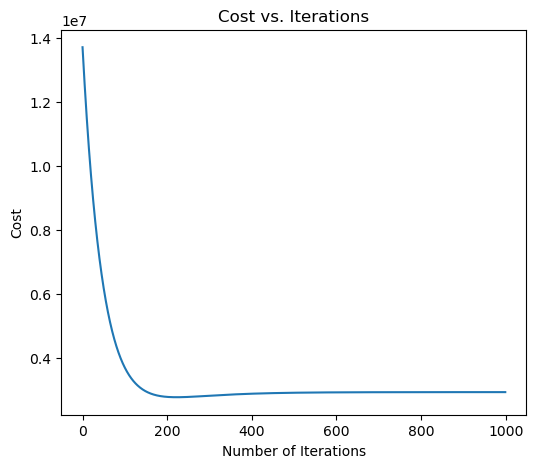

In [20]:
# Training the model
lr.train(X_train, y_train, 1000)

In [21]:
lr.save(filename="slr_one_variable.pkl")

In [49]:
model = SimpleLinearRegression.load("slr_one_variable.pkl")

## Model Evaluation

The EvaluateModel class below includes three methods that allow us to calculate key performance metrics for evaluating our model: Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and R-squared (R²).

#### Mean Squared Error (MSE)

The Mean Squared Error (MSE) measures the average squared difference between the actual and predicted values. It is defined by the following formula:


$$ MSE = \frac{1}{m} \sum_{i=1}^{n} (\hat{y}^{(i)} - y^{(i)})^2$$


#### Root Mean Squared Error (RMSE)

The Root Mean Squared Error (RMSE) is the square root of the Mean Squared Error (MSE). It provides a measure of the error in the same units as the target values, which makes it more interpretable. The formula for RMSE is:


$$ RMSE = \sqrt{MSE} = \sqrt{\frac{1}{m} \sum_{i=1}^{n} (\hat{y}^{(i)} - y^{(i)})^2} $$


#### R-squared (R²)

The R-squared (R²) value indicates how well the model’s predictions match the actual values. It is defined as:


$$R^2 = 1- \frac{RSS}{TSS} =1 - \frac{\sum_{i=1}^{m} (\hat{y}^{(i)} - y^{(i)})^2}{\sum_{i=1}^{m} ({y}^{(i)} - \bar y)^2}$$


Where:

$\bar{y}$  is the mean of the actual values.

The numerator is the Residual Sum of Squares (RSS).

The denominator is the Total Sum of Squares (TSS).

In [50]:
class EvaluateModel:
    """
    A class to evaluate the performance of a model using different metrics.
    """

    @staticmethod
    def mse(y_actual, y_prediction):
        """
        Calculate the Mean Squared Error (MSE) between the actual and predicted values.

        Args:
        y_actual (array-like): The actual values.
        y_prediction (array-like): The predicted values from the model.

        Returns:
        float: The MSE value.
        
        Raises:
        AssertionError: If the lengths of y_actual and y_prediction do not match.
        ValueError: If input arrays are empty or not valid (non-numeric or non-array).
        """
        # Check if inputs are valid (non-empty and numpy arrays)
        if not isinstance(y_actual, (np.ndarray, list)) or not isinstance(y_prediction, (np.ndarray, list)):
            raise ValueError("Inputs should be of type list or numpy array.")
        if len(y_actual) == 0 or len(y_prediction) == 0:
            raise ValueError("Input arrays cannot be empty.")
        
        # Ensure that both the actual and predicted values have the same length
        if len(y_actual) != len(y_prediction):
            raise AssertionError("Please ensure they are of the same length")
        
        # Calculate and return the Mean Squared Error
        return np.mean(np.square(np.array(y_actual) - np.array(y_prediction)))

    @staticmethod
    def rmse(y_actual, y_prediction):
        """
        Calculate the Root Mean Squared Error (RMSE) between the actual and predicted values.
        RMSE is simply the square root of the MSE.

        Args:
        y_actual (array-like): The actual values.
        y_prediction (array-like): The predicted values from the model.

        Returns:
        float: The RMSE value.

        Raises:
        ValueError: If inputs are empty or not valid (non-numeric or non-array).
        """
        # Calculate the Mean Squared Error first
        mse = EvaluateModel.mse(y_actual, y_prediction)
        
        # Return the square root of MSE to get RMSE
        return np.sqrt(mse)

    @staticmethod
    def rsquared(y_actual, y_prediction):
        """
        Calculate the R-squared (R²) value, which indicates how well the model's predictions match the actual values.

        Args:
        y_actual (array-like): The actual values.
        y_prediction (array-like): The predicted values from the model.

        Returns:
        float: The R-squared value (ranging from 0 to 1). 
               A higher value indicates better model performance.

        Raises:
        ValueError: If inputs are empty or not valid (non-numeric or non-array).
        """
        # Check if inputs are valid (non-empty and numpy arrays)
        if not isinstance(y_actual, (np.ndarray, list)) or not isinstance(y_prediction, (np.ndarray, list)):
            raise ValueError("Inputs should be of type list or numpy array.")
        if len(y_actual) == 0 or len(y_prediction) == 0:
            raise ValueError("Input arrays cannot be empty.")
        
        # Total Sum of Squares (TSS) is the total variance in the actual values
        tss = np.sum(np.square(np.array(y_actual) - np.mean(y_actual)))
        
        # Residual Sum of Squares (RSS) is the variance between the actual and predicted values
        rss = np.sum(np.square(np.array(y_actual) - np.array(y_prediction)))
        
        # R-squared is 1 minus the ratio of RSS to TSS
        r2 = 1 - (rss / tss)
        
        return r2

In [51]:
y_predict = model.predict_values(X_test)

In [52]:
mse_output = EvaluateModel.mse(y_test, y_predict)
rmse_output = EvaluateModel.rmse(y_test, y_predict)
r2_output = EvaluateModel.rsquared(y_test, y_predict)

In [53]:
print(f"Mean Squared Error (MSE): {mse_output}")
print(f"Root Mean Squared Error (RMSE): {rmse_output}")
print(f"R-squared (Coefficient of Determination): {r2_output}")

Mean Squared Error (MSE): 4.365735133216795
Root Mean Squared Error (RMSE): 2.0894341658010656
R-squared (Coefficient of Determination): 0.9882193457191714


### Thank You

In [56]:
x_axis = len(X_test)


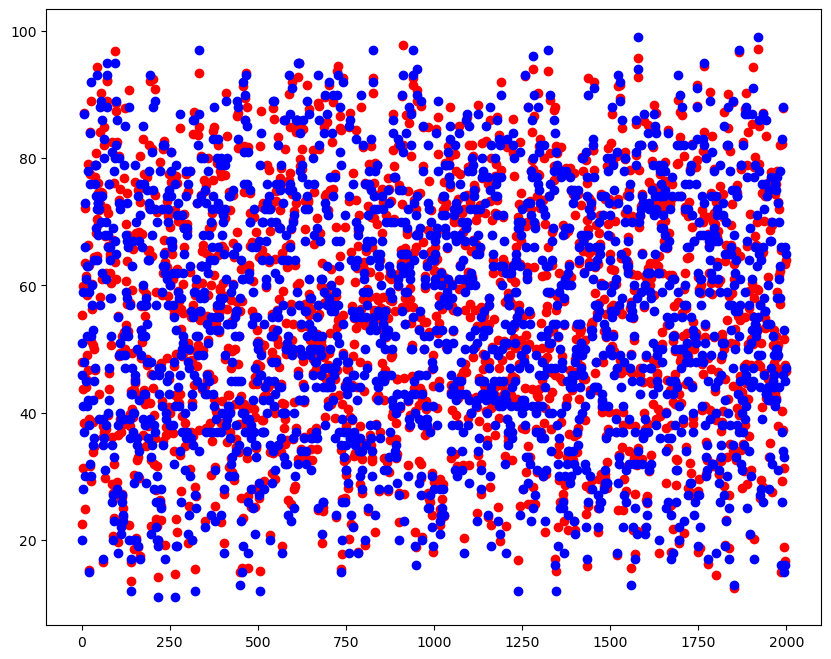

In [63]:
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter([x for x in range(x_axis)], y_predict, color="red")
ax.scatter([x for x in range(x_axis)], y_test, color="blue")